In [30]:
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

In [31]:
df = pd.read_csv('us-states.csv')
df

,date,state,fips,cases,deaths
0,2020-01-21,Washington,53,1,0
1,2020-01-22,Washington,53,1,0
2,2020-01-23,Washington,53,1,0
3,2020-01-24,Illinois,17,1,0
4,2020-01-24,Washington,53,1,0
...,...,...,...,...,...
1432,2020-03-28,Virginia,51,740,17
1433,2020-03-28,Washington,53,4311,191
1434,2020-03-28,West Virginia,54,113,0
1435,2020-03-28,Wisconsin,55,1042,17


In [32]:
df['date']=df['date'].apply(lambda x:pd.Timestamp(x))
df.dtypes

date      datetime64[ns]
state             object
fips               int64
cases              int64
deaths             int64
dtype: object

In [33]:
df.set_index('date',inplace=True)
df

,state,fips,cases,deaths
date,,,,
2020-01-21,Washington,53,1,0
2020-01-22,Washington,53,1,0
2020-01-23,Washington,53,1,0
2020-01-24,Illinois,17,1,0
2020-01-24,Washington,53,1,0
...,...,...,...,...
2020-03-28,Virginia,51,740,17
2020-03-28,Washington,53,4311,191
2020-03-28,West Virginia,54,113,0


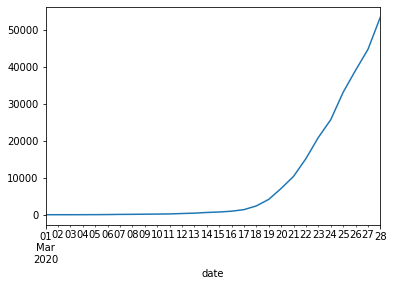

In [38]:
df[df['state']=='New York'].loc[:,'cases'].plot()

In [35]:
df.index

DatetimeIndex(['2020-01-21', '2020-01-22', '2020-01-23', '2020-01-24',
               '2020-01-24', '2020-01-25', '2020-01-25', '2020-01-25',
               '2020-01-26', '2020-01-26',
               ...
               '2020-03-28', '2020-03-28', '2020-03-28', '2020-03-28',
               '2020-03-28', '2020-03-28', '2020-03-28', '2020-03-28',
               '2020-03-28', '2020-03-28'],
              dtype='datetime64[ns]', name='date', length=1437, freq=None)